# Background and Context
Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.


# Objective
Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

# Data Dictionary
* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values 
                    0=No ( Customer did not leave the bank )

                    1=Yes ( Customer left the bank )

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, classification_report, roc_auc_score, roc_curve

# Import Data

In [2]:
bank = pd.read_csv("bank.csv")

In [3]:
df = bank.copy()

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.shape

(10000, 14)

- The dataset consists of 10000 rows and 14 columns.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- `Surname`, `Geography` and `Gender` are objects. Others are numbers.

## Check missing values

In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

- No missing values.

## Check duplicates

In [8]:
any(df.duplicated())

False

- No duplicate rows.

## Check unique values

In [9]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

- It seems `RowNumber` and `CustomerId` and are not releveant features, as we have distinct `RowNumber` and `CustomerId` for each customer.
- By common sense, we know `Surname` should not correlate with churn rate.

### Drop `RowNumber`, `CustomerId`, `Surname`

In [10]:
df = df.drop(columns = ["RowNumber", "CustomerId", "Surname"])

## Data Summary

In [11]:
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,NaN,NaN,NaN,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,NaN,NaN,NaN,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,NaN,NaN,NaN,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,NaN,NaN,NaN,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


- The ranges of features vary from 0 to 250000. We will need to do scale transformation before model building. 

# Univariate Analysis

In [12]:
def hist_box_plot(col):
    plt.figure(figsize = (15,5));
    plt.subplot(121);
    sns.histplot(x = col, data = df, kde = True);
    plt.subplot(122);
    sns.boxplot(x = col, data = df, showmeans = True, color = "yellow");

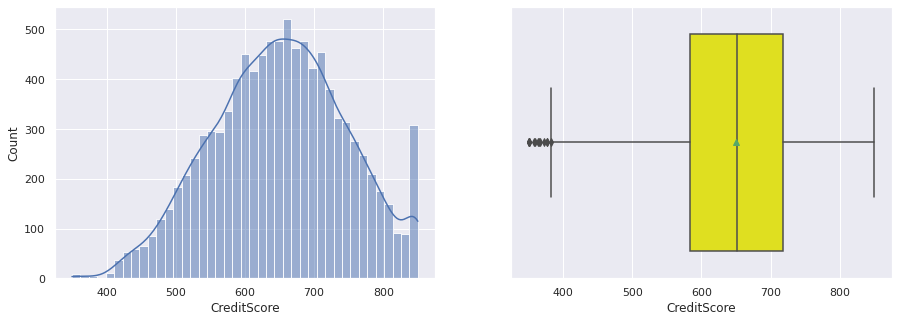

In [13]:
hist_box_plot("CreditScore")

- `CreditScore` approaches normal distribution and ranges from 350 to 850, with almost equal mean and median. A few outliers on the left.

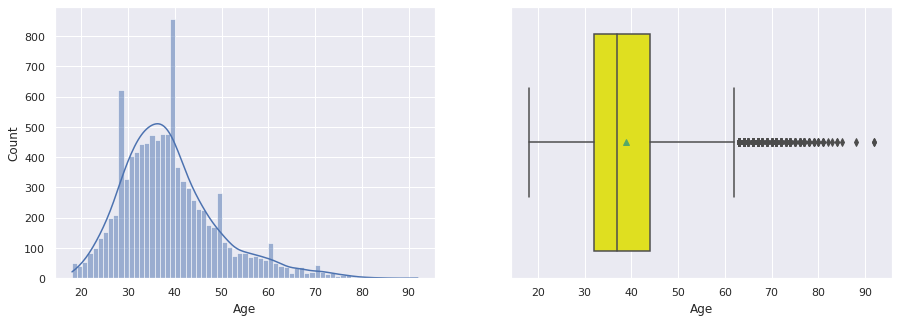

In [14]:
hist_box_plot("Age")

- `Age` is right-skewed and varies from 18 to 90+. About 50% are under 35 years old. A number of outliers on the right.

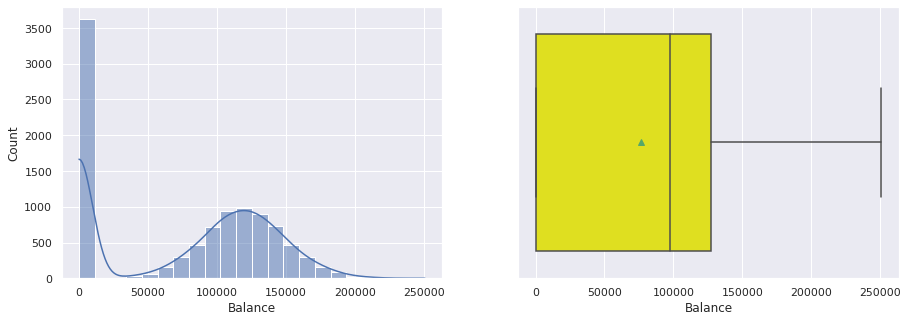

In [15]:
hist_box_plot("Balance")

- At least 25% of the customers are with zero account balance. The remainings approaches normal distribution.

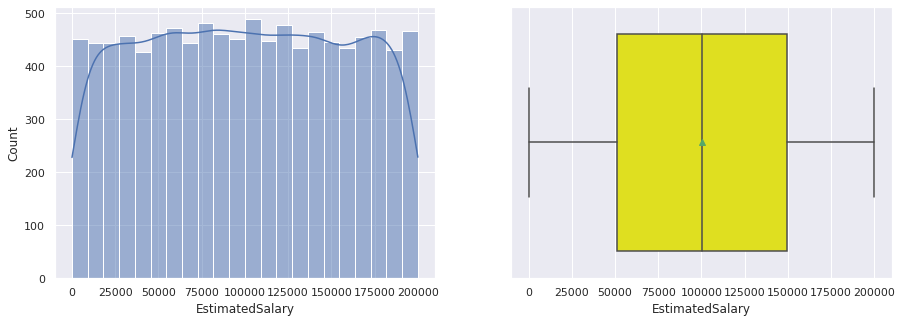

In [16]:
hist_box_plot("EstimatedSalary")

- `EstimatedSalary` is evenly distributed with equal mean and median.

In [17]:
def countplot(col, figsize):
    plt.figure(figsize = figsize)
    ax = sns.countplot(x = col, data = df);
    for p in ax.patches:
        x, y = p.get_x(), p.get_y()
        h, w = p.get_height(), p.get_width()
        percent = np.round(h / df.shape[0] * 100, 2)
        plt.annotate(xy = (x + w/2 - 0.3, y + h), text = str(percent) + "%")

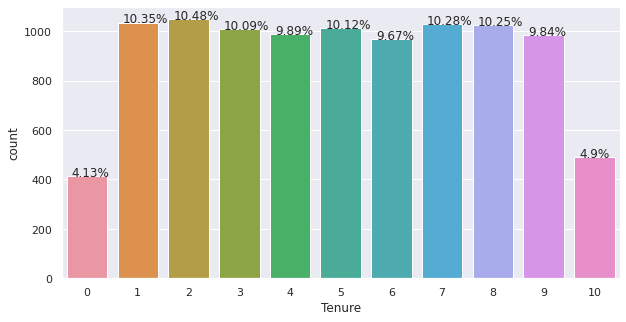

In [18]:
countplot("Tenure", figsize = (10,5))

- Most customers has been with our bank for 1 - 9 years, and they are evenly distributed in this range.
- 4% of customers are new customers with less than 1 year of relationship.
- 5% of customers are loyal customers with 10 years of relationship.

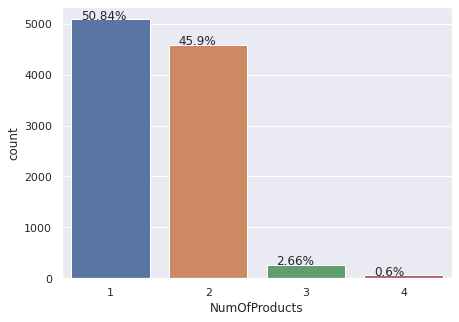

In [19]:
countplot("NumOfProducts", figsize = (7,5))

- 50.8% of customers bought 1 product and 46% of customers bought 2 products.
- 3% of customers bought more than two products.

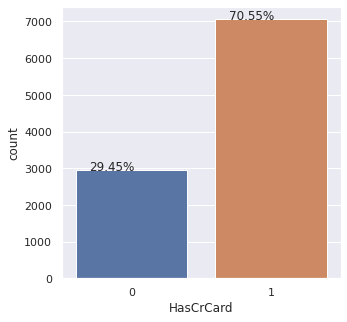

In [20]:
countplot("HasCrCard", figsize = (5,5))

- More than 70% of the customers have credit cards.

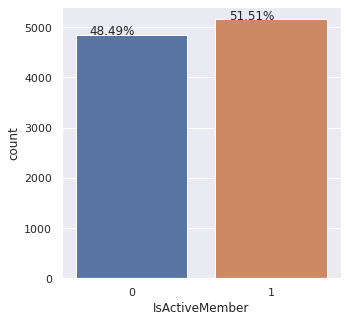

In [21]:
countplot("IsActiveMember", figsize = (5,5))

- About half of customers are active members.

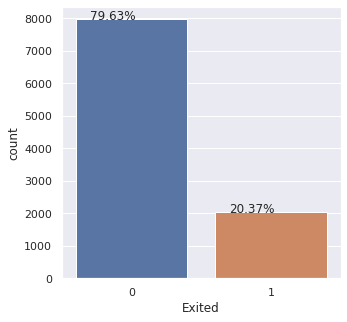

In [22]:
countplot("Exited", figsize = (5,5))

- Imbalanced class. About 20% churn rate.

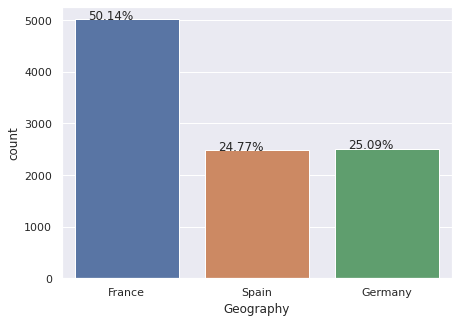

In [23]:
countplot("Geography", figsize = (7,5))

- Half of the customers come from France. The remainings are evenly distributed in Spain and Germany.

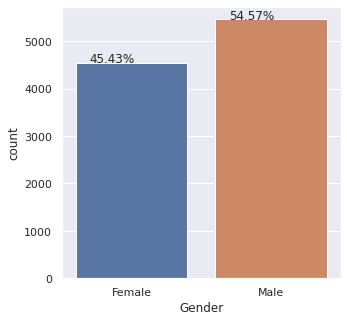

In [24]:
countplot("Gender", figsize = (5,5))

More male than female, with 56% of the total are male.

# Bivariate Analysis
## Pairplot

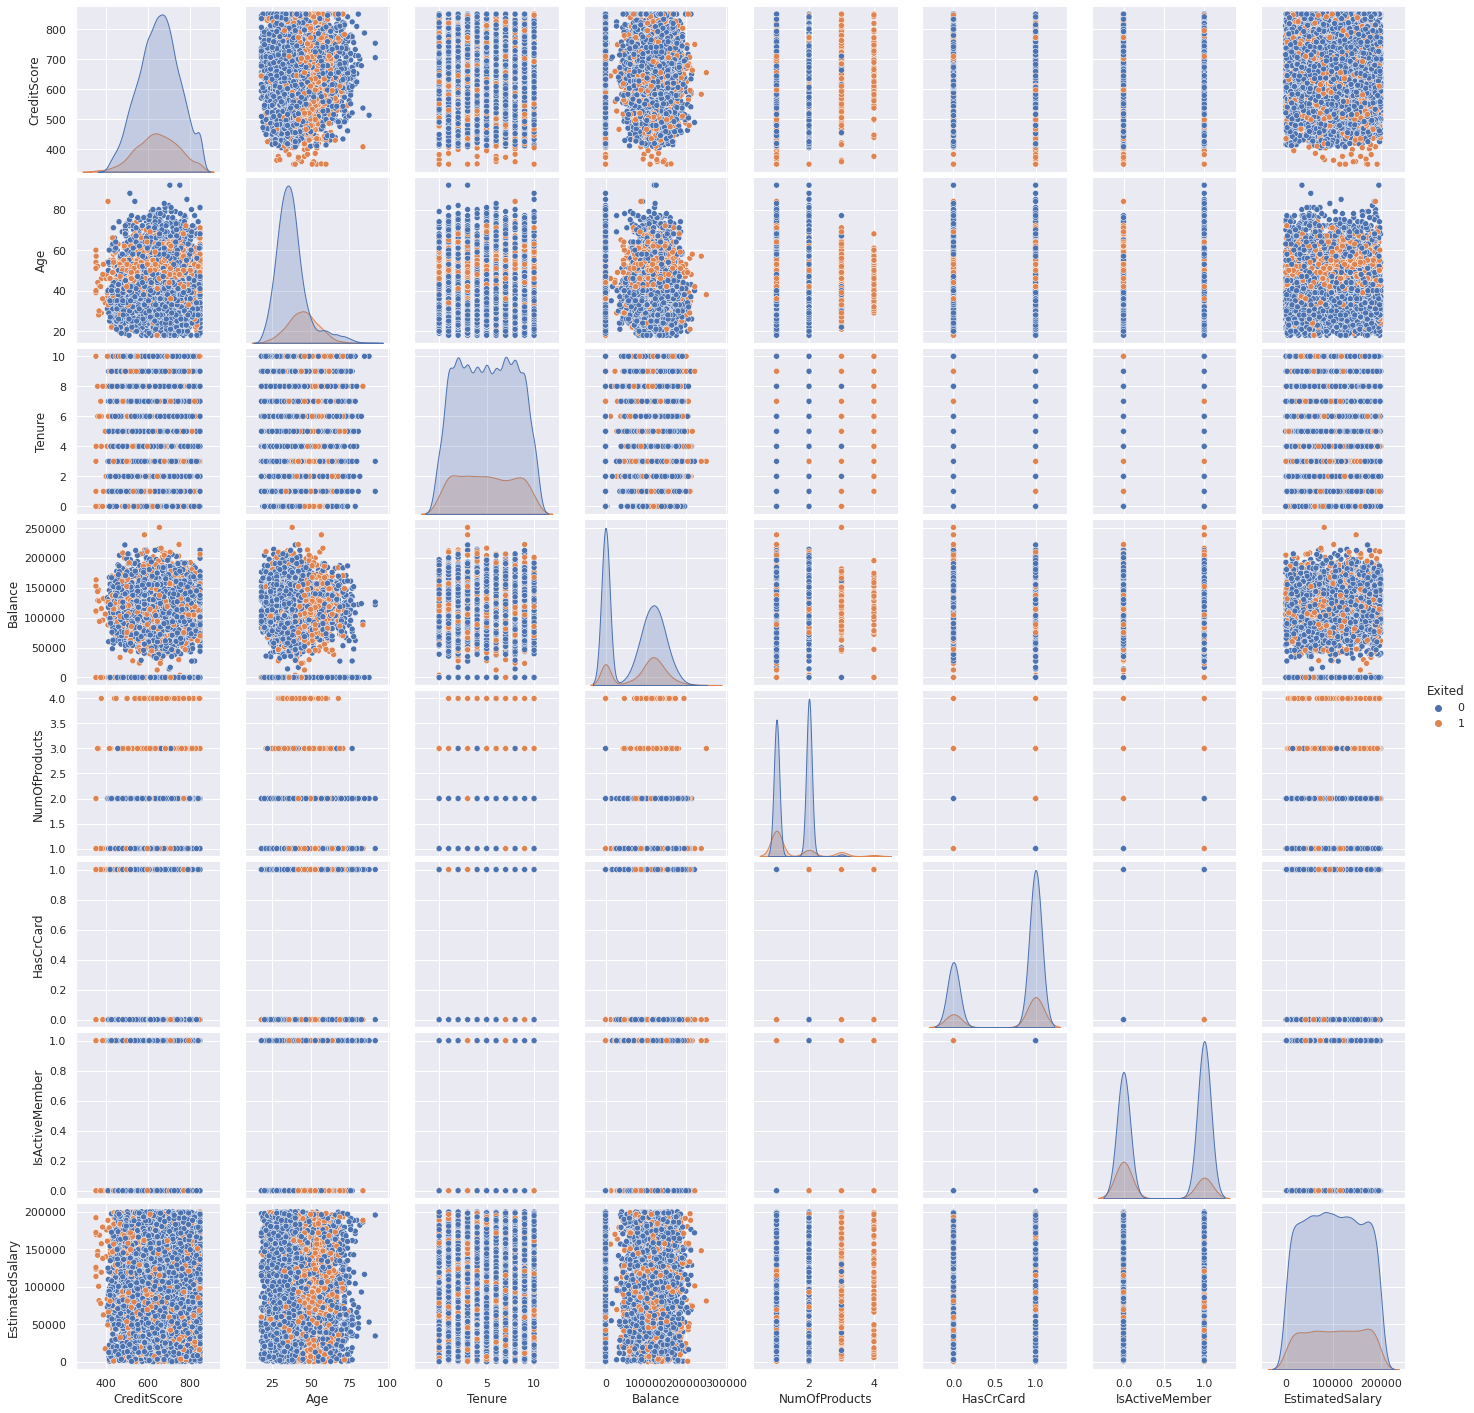

In [25]:
sns.pairplot(data = df, diag_kind = "kde", hue = "Exited");

## Heatmap

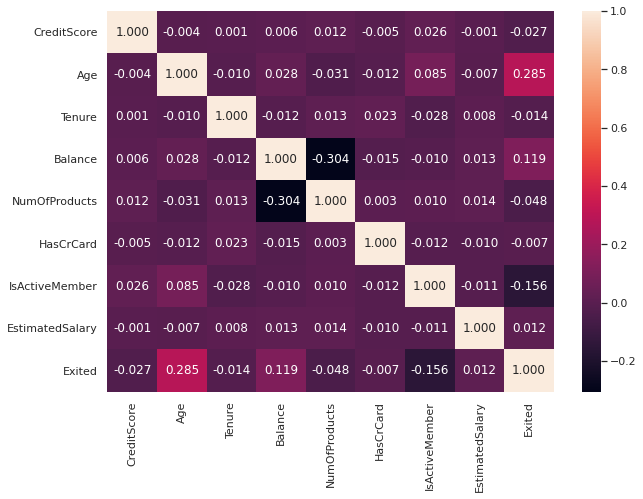

In [26]:
plt.figure(figsize = (10,7));
sns.heatmap(data = df.corr(), fmt = ".3f", annot = True);

- `NumOfProducts` is negatively correlated to `Balance`.
- `Exited` is positively correlated to `Age`.

## Exited vs Age

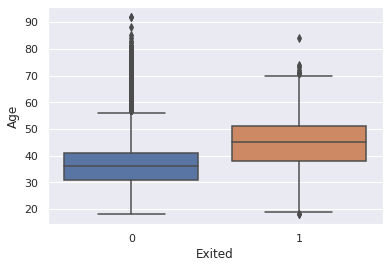

In [27]:
sns.boxplot(x = "Exited", y = "Age", data = df);

- Older customers tend to churn, whose median age is about 45, while the median age of non-churned customers is about 35. Both groups have a number of outliers on the upper end.

## Exited vs CreditScore

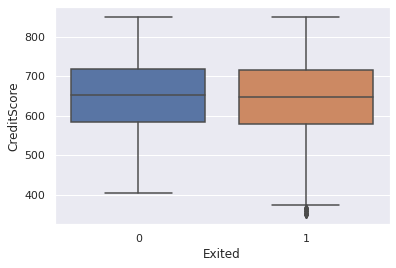

In [28]:
sns.boxplot(x = "Exited", y = "CreditScore", data = df);

- Both groups have similar credit score distribution. 

## Exited vs Geography

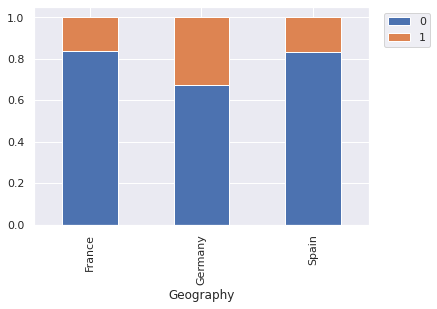

In [29]:
pd.crosstab(index = df.Geography, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Germany has the highest churn rate of around 30%, while France and Spain have almost equal churn rate of around 18%.

## Exited vs Gender

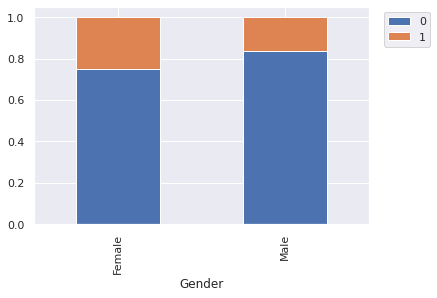

In [30]:
pd.crosstab(index = df.Gender, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Female has higher churn rate than male.

## Exited vs Tenure

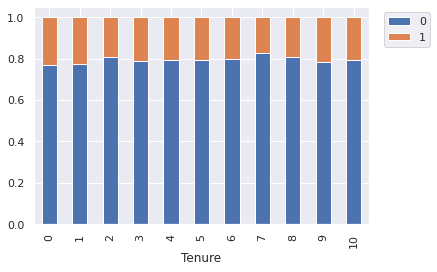

In [31]:
pd.crosstab(index = df.Tenure, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Tenure doesn't affect churn rate much.

## Exited vs Balance

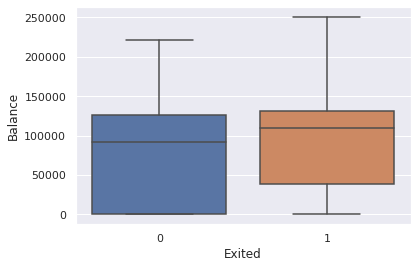

In [32]:
sns.boxplot(x = "Exited", y = "Balance", data = df);

- Churned customers have higher balance.

## Exited vs NumOfProducts

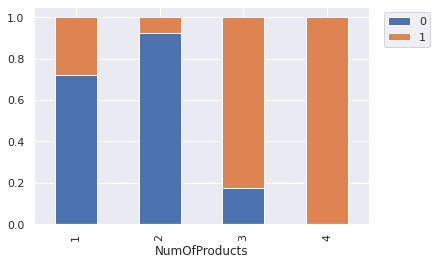

In [33]:
pd.crosstab(index = df.NumOfProducts, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Customers who bought 3 or 4 products through our bank have significantly higher churn rate.
- Customers who bought 2 products through our bank have the lowest churn rate.
- It may indicate there's something wrong with our products, which makes our customers unhappy and finally drives them to the decision of leaving us.

## Exited vs HasCrCard

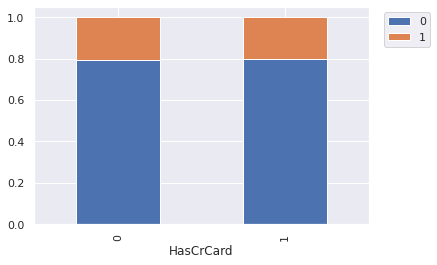

In [34]:
pd.crosstab(index = df.HasCrCard, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Whether having credit cards doesn't affect churn rate.

## Exited vs IsActiveMember

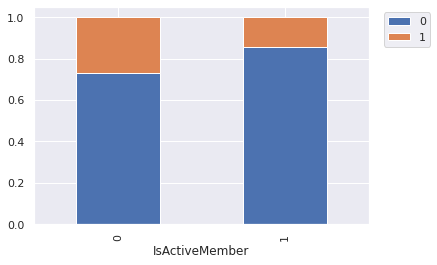

In [35]:
pd.crosstab(index = df.IsActiveMember, columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Active members are less likely to churn.

## Exited vs EstimatedSalary

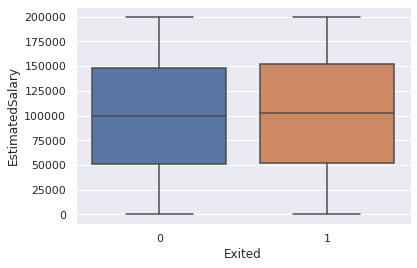

In [36]:
sns.boxplot(x = "Exited", y = "EstimatedSalary", data = df);

- Both groups show similar `EstimatedSalary` distribution.

## Exited vs Geography vs Age

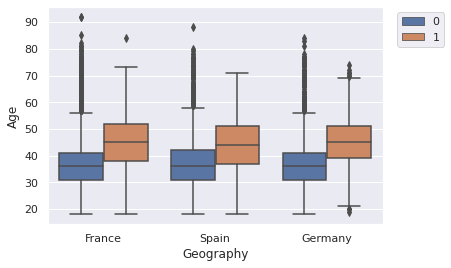

In [37]:
sns.boxplot(x = "Geography", y = "Age", hue = "Exited",data = df);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Median age is higher for churned group among all three countries.

## Exited vs Geography vs Gender

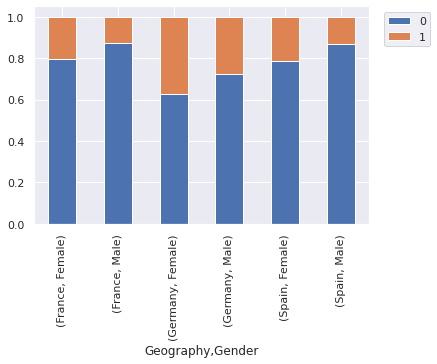

In [38]:
pd.crosstab(index = [df.Geography, df.Gender], columns = df.Exited, normalize = "index").plot(kind = "bar", stacked = True);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- Female is more likely to churn than male no matter in any of the three countries.

## Exited vs NumOfProducts vs EstimatedSalary

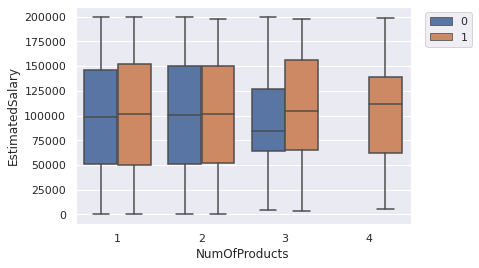

In [39]:
sns.boxplot(x = "NumOfProducts", y = "EstimatedSalary", hue = "Exited", data = df);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- For customers who bought the same amount of products, the churned group always has equal or higher estimated salary than the non-churned group. 
- The median estimated salary of churned customers who bought 4 products is the highest among all churned groups.

## Exited vs Geography vs Tenure

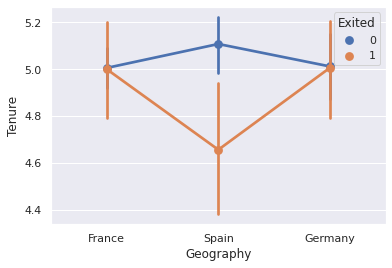

In [40]:
sns.pointplot(x = "Geography", y = "Tenure", hue = "Exited", data = df);

- Churned customers in Spain have lower tenure than non-churned customers, while in France and Germany both groups have equal tenure.

## Exited vs Gender vs Tenure

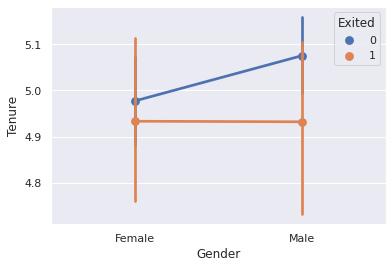

In [41]:
sns.pointplot(x = "Gender", y = "Tenure", hue = "Exited", data = df);

- Churned customers have lower tenure for both genders.

## Exited vs Age vs EstimatedSalary

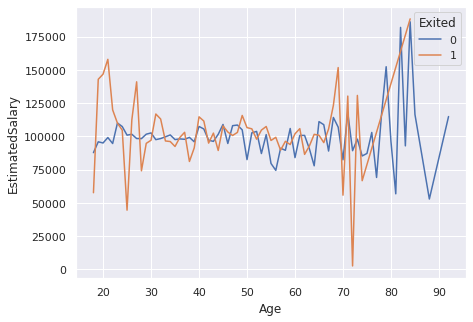

In [42]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "EstimatedSalary", hue = "Exited", data = df, ci = None);

- Churned customers tend to have more unstable estimated salary than non-churned customers.

## Exited vs Age vs CreditScore

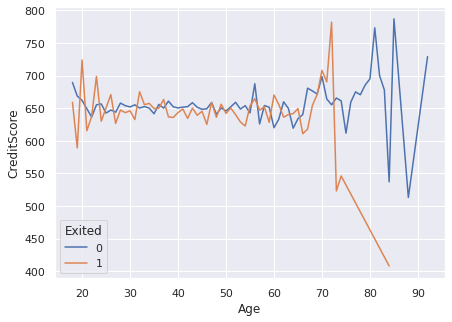

In [43]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "CreditScore", hue = "Exited", data = df, ci = None);

- Churned customers older than 72 show a sharp decline of credit score compared to non-churned customers at the same age.

## Exited vs Age vs Balance

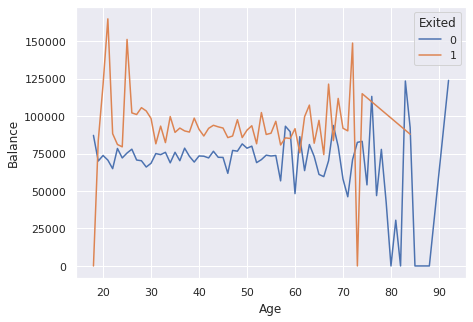

In [44]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "Balance", hue = "Exited", data = df, ci = None);

- Generally speaking, churned customers have higher balance at all ages.

## Exited vs Age vs Tenure

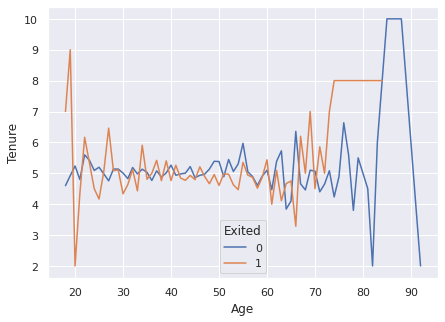

In [45]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Age", y = "Tenure", hue = "Exited", data = df, ci = None);

- Both groups show equal average tenure of about 5 years before 70 years old. Churned group shows increased tenure after 70 years old, while non-churned group shows a decline of tenure before 80 and then an increase of tenure after 80.

## Exited vs Geography vs Balance

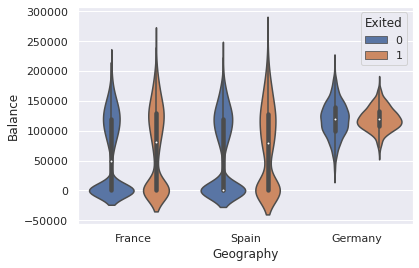

In [46]:
sns.violinplot(x = "Geography",y = "Balance", hue = "Exited", data = df);

- In Germany, both groups have similar distribution of balance. The range of balance for both groups is much narrower than the other two countries.
- In Spain, the median balance of churned group is much higher than the non-churned group. In the non-churned group, at least half have zero balance.
- In France, the median balance of churned group is slightly higher than the non-churned group. The range of balance for both groups is similar to that of Spain.

## Exited vs Gender vs EstimatedSalary

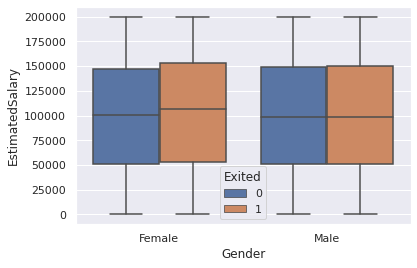

In [47]:
sns.boxplot(x = "Gender",y = "EstimatedSalary", hue = "Exited", data = df);

- Female churned customers have slightly higher estimated salary than non-churned female customers. For male, both groups show identical distribution of estimated salary.

## Exited vs Tenure vs Balance

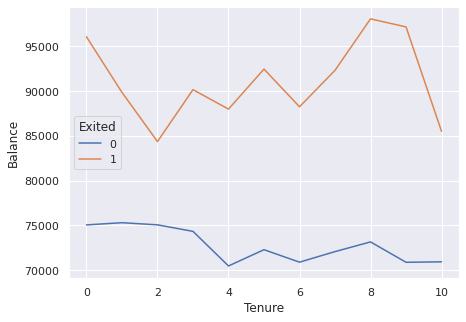

In [48]:
plt.figure(figsize = (7,5));
sns.lineplot(x = "Tenure", y = "Balance", hue = "Exited", data = df, ci = None);

- Churned customers with any tenure always have higher balance.

## Exited vs Tenure vs CreditScore

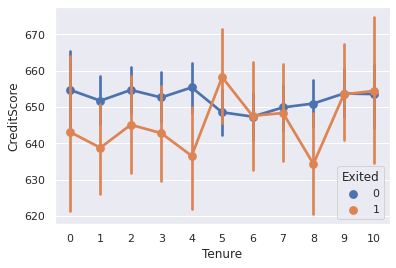

In [49]:
sns.pointplot(x = "Tenure", y = "CreditScore", hue = "Exited", data = df);

- Churned customers with 5 years of tenure have the highest average credit score among customers in any combinations of `Exited` and `Tenure`. They also have higher credit score than non-churned customers with the same tenure, while non-churned customers with other tenure length tend to have higher credit score than churned customers with the same tenure.

## Exited vs Tenure vs EstimatedSalary

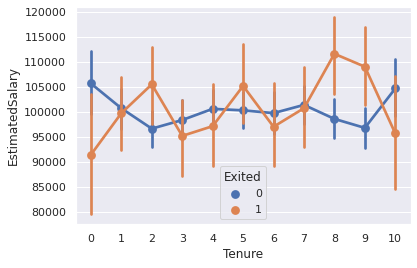

In [50]:
sns.pointplot(x = "Tenure", y = "EstimatedSalary", hue = "Exited", data = df);

- Churned customers with long tenure of 8/9 years have the highest estimated salary.

## Exited vs NumOfProducts vs Balance

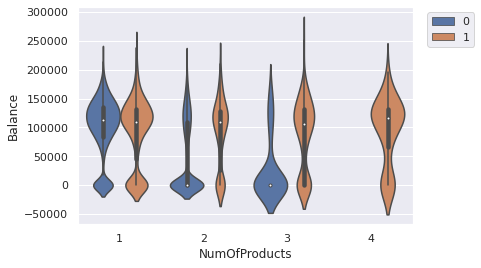

In [51]:
sns.violinplot(x = "NumOfProducts", y = "Balance", hue = "Exited", data = df);
plt.legend(bbox_to_anchor = (1.2,1), loc = "upper right");

- For customers who bought the same amount of products, the churned group always has equal or higher balance than the non-churned group. 
- The median balance of churned customers who bought 4 products is the highest among all churned groups.

## Geography vs Balance

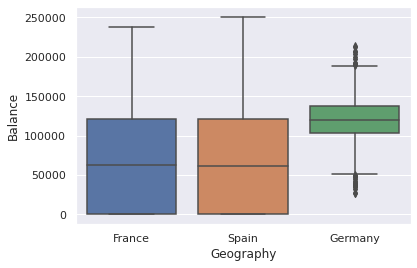

In [52]:
sns.boxplot(x = "Geography", y = "Balance", data = df);

- Customers at Germany have the highest median balance among three countries.

# Data Pre-processing

## Create dummy variable

In [53]:
backup1 = df.copy()   # for debug use

In [54]:
df = backup1.copy()   # for debug use

In [55]:
df = pd.get_dummies(df, drop_first = True);
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## Split data

In [56]:
X = df.drop(columns = ["Exited"])
y = df.Exited

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 17, shuffle = True, stratify = y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 17, shuffle = True, stratify = y_train)
print("Train set size: ", X_train.shape, y_train.shape)    # 64% for training set
print("Validation set size: ", X_valid.shape, y_valid.shape)  # 16% for validation set
print("Test set size: ", X_test.shape, y_test.shape)   # 20% for test set

Train set size:  (6400, 11) (6400,)
Validation set size:  (1600, 11) (1600,)
Test set size:  (2000, 11) (2000,)


In [58]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4941,640,43,9,172478.15,1,1,0,191084.40,0,1,1
7747,850,24,6,0.00,2,1,1,13159.90,0,0,0
450,494,38,7,174937.64,1,1,0,40084.32,1,0,0
8264,742,33,6,0.00,2,0,0,38550.40,0,0,1
8485,670,25,7,0.00,2,1,1,144723.38,0,0,1


## Scaling

In [59]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Model building

## Metrics
**When we make a prediction, there're two types of errors:**
- Type I error (False Positive): A customer isn't going to churn, but we predict she/ he plans to. If we make this type of error, we will lose nothing.
- Type II error (Flase Negative): A customer is going to churn, but we predict she/ he doesn't. If we make this type of error, we may lose a valuable customer and the revenue associated with her/his accounts and transactions.

**Our goal is to identify as many churned customers as possible, therefore we should use recall and accuracy as metrics.**

In [60]:
def iteration_loss(history):
    plt.figure(figsize = (20,5));
    plt.subplot(121);   # plot accuracy curve
    plt.plot(history.history["accuracy"], label = "train");
    plt.plot(history.history["val_accuracy"], label = "validation");
    plt.legend(loc = "lower right");
    plt.title("Accuracy");

    plt.subplot(122);    # plot loss curve
    plt.plot(history.history["loss"], label = "train");
    plt.plot(history.history["val_loss"], label = "validation");
    plt.legend(loc = "upper right");
    plt.title("Loss");

In [61]:
def roc_auc(y_true, y_prob):
    fpr, tpr, threshold = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize = (5,5));
    plt.plot([0,1],[0,1], "r--", label = "base");
    plt.plot(fpr, tpr, "b--", label = "roc-auc");
    plt.xlim(-0.01, 1.01);
    plt.ylim(-0.01, 1.01);
    plt.xlabel("FPR");
    plt.ylabel("TPR");
    plt.legend(loc = "lower right");
    plt.title("AUC score:" + str(np.round(auc, 3)));
    return fpr, tpr, threshold

## Model 1
### Build the model

In [62]:
# construct a NN with only one output layer
model1 = keras.Sequential()
model1.add(keras.layers.Dense(units = 1, activation = "sigmoid", kernel_initializer= "glorot_normal"))

# use Adam as optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# use binary_crossentropy as loss function and accuracy as metrics
model1.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])

# batch size set to 64, run 50 epochs
history = model1.fit(X_train, y_train,batch_size=64, epochs=50, validation_data=(X_valid, y_valid), validation_batch_size = 64)  

Epoch 1/50
100/100 [==============================] - 1s 2ms/step - loss: 0.7252 - accuracy: 0.6019 - val_loss: 0.6959 - val_accuracy: 0.6025
Epoch 2/50
100/100 [==============================] - 0s 1ms/step - loss: 0.6637 - accuracy: 0.6478 - val_loss: 0.6429 - val_accuracy: 0.6562
Epoch 3/50
100/100 [==============================] - 0s 1ms/step - loss: 0.6170 - accuracy: 0.6961 - val_loss: 0.6025 - val_accuracy: 0.6988
Epoch 4/50
100/100 [==============================] - 0s 1ms/step - loss: 0.5811 - accuracy: 0.7362 - val_loss: 0.5715 - val_accuracy: 0.7437
Epoch 5/50
100/100 [==============================] - 0s 1ms/step - loss: 0.5534 - accuracy: 0.7581 - val_loss: 0.5473 - val_accuracy: 0.7575
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.5316 - accuracy: 0.7725 - val_loss: 0.5280 - val_accuracy: 0.7719
Epoch 7/50
100/100 [==============================] - 0s 1ms/step - loss: 0.5142 - accuracy: 0.7887 - val_loss: 0.5125 - val_accuracy: 0.7831
Epoch 

- Print the architecture of model1:

In [63]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (64, 1)                   12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


- This model only has one output layer and no hidden layer.

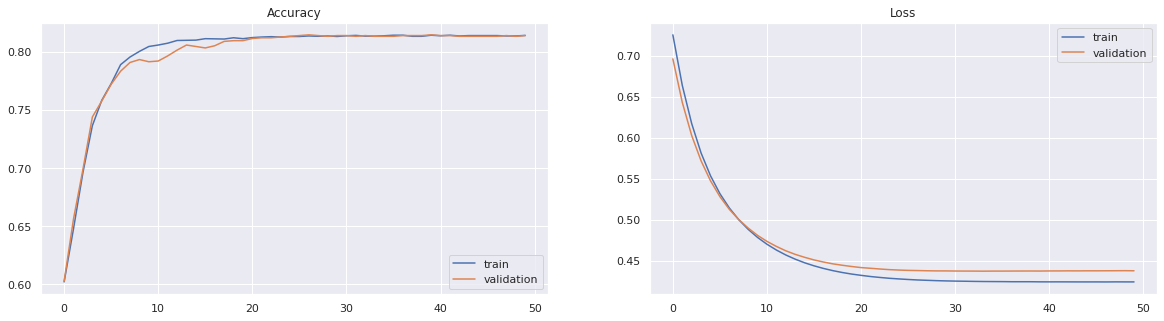

In [64]:
iteration_loss(history)

- After 20 epochs, both the accuracy curve and loss curve flatten. Training set and validation set fit well.

In [65]:
loss, acc = model1.evaluate(X_test, y_test)
print("Test set loss: ", loss)
print("accuracy: ", acc)

63/63 [==============================] - 0s 2ms/step - loss: 0.4357 - accuracy: 0.7995
Test set loss:  0.435677170753479
accuracy:  0.7994999885559082


- Test set accuracy is 0.80, matching the accuracy of train and validation set.

### Use ROC- AUC curve to find optimal threshold

In [66]:
y_train_prob = model1.predict(X_train)
y_train_prob

array([[0.28483212],
       [0.02597582],
       [0.48855007],
       ...,
       [0.30928195],
       [0.25978294],
       [0.05546442]], dtype=float32)

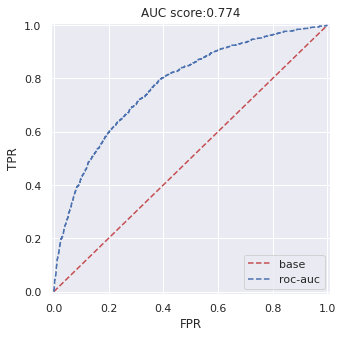

In [67]:
fpr, tpr, threshold = roc_auc(y_train, y_train_prob)

In [68]:
idx = np.argmax(tpr - fpr)  # the index at which tpr and fpr achieve the maximum difference
optimal_thresh = threshold[idx]
print("optimal threshold:", optimal_thresh)

optimal threshold: 0.16330668


### Evaluate model performance

In [69]:
def performance_metrics(model, thresh):
    y_train_pred = (model.predict(X_train)) > thresh
    y_valid_pred = (model.predict(X_valid)) > thresh
    y_test_pred = (model.predict(X_test)) > thresh
    
    m = []
    m.append(accuracy_score(y_train, y_train_pred))
    m.append(accuracy_score(y_valid, y_valid_pred))
    m.append(accuracy_score(y_test, y_test_pred))    

    m.append(recall_score(y_train, y_train_pred))
    m.append(recall_score(y_valid, y_valid_pred))
    m.append(recall_score(y_test, y_test_pred))
    
    metrics = pd.DataFrame(data = m, index = ["Train accuracy", "Validation accuracy", "Test accuracy", "Train recall", "Validation recall", "Test recall"])
    return y_test_pred, metrics.T

In [70]:
def show_confusion_matrix(y_true, y_pred, labels = [0, 1]):
    matrix = confusion_matrix(y_true, y_pred, labels = labels)
    matrix_df = pd.DataFrame(matrix)
    
    group_counts = ["{0:0.0f}".format(value) for value in matrix.flatten()]   # absolute value
    group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]    # percent
    plot_labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    plot_labels = np.asarray(plot_labels).reshape(2,2)   # reshape into a n_class x n_class ndarray
    
    plt.figure(figsize = (7,5))
    sns.heatmap(matrix_df, annot = plot_labels, fmt='')
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')

In [71]:
metrics = {}    # a dictionary to keep track of performance of different models

In [72]:
y_test_pred, metrics["M1"] = performance_metrics(model1, optimal_thresh)
metrics["M1"]

,Train accuracy,Validation accuracy,Test accuracy,Train recall,Validation recall,Test recall
0,0.652188,0.63375,0.639,0.792178,0.751534,0.781327


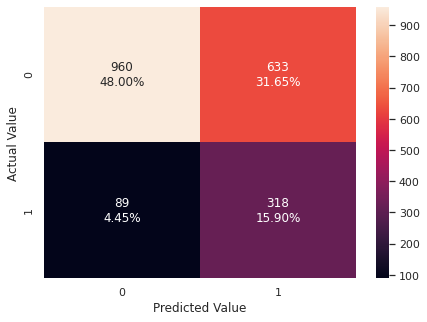

In [73]:
show_confusion_matrix(y_test, y_test_pred)

- Train/ Validation/ Test set fit well. Accuracy is about 0.64, recall is about 0.77.

In [74]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      1593
           1       0.33      0.78      0.47       407

    accuracy                           0.64      2000
   macro avg       0.62      0.69      0.60      2000
weighted avg       0.80      0.64      0.67      2000



- The model generates decent recall scores for both classes. But precision for class 0 is much higher than precision for class 1. Overall accuracy is 0.64 and recall score is 0.69.

Let's improve it.

## Model 2

# Conclusion
- Older customers are more likely to churn no matter in any of the three countries.
- Customers at Germany have the highest median balance and churn rate among three countries.
- Female is more likely to churn than male no matter in any of the three countries.
- Customers with higher balance are more likely to churn at all ages.
- Active members are less likely to churn.
- Customers who bought 3 or 4 products through our bank have significantly higher churn rate. It may indicate there's something wrong with our products, which makes our customers unhappy and finally drives them to the decision of leaving.

- For customers who bought the same amount of products, the churned group always has equal or higher estimated salary/balance than the non-churned group. The median estimated salary/balance of churned customers who bought 4 products is the highest among all churned groups.
- Churned customers in Spain have lower tenure than non-churned customers, while in France and Germany both groups have equal tenure.
- Churned customers have lower tenure for both genders.
- Churned customers tend to have more unstable estimated salary than non-churned customers.
- Churned customers older than 72 show a sharp decline of credit score.
- Female churned customers have slightly higher estimated salary than non-churned female customers. For male, both groups show identical distribution of estimated salary.
- Churned customers with any tenure always have higher balance.
- Churned customers with 5 years of tenure have the highest average credit score among customers in any combinations of `Exited` and `Tenure`. 
- Churned customers with long tenure of 8/9 years have the highest estimated salary.




# Recommendation
- Customers who bought 3 or 4 products through our bank show significantly higher churn rate. Need to investigate what products they bought and what cause them to leave. If necessary, implement survey among all customers to find out their opinions about our products, and overhaul the design of our products and service quality.
- As Germany has higher churn rate and median balance than other two countries, we need to improve marketing and perform promotions in Germany.
- As customers with higher balance are more likely to churn at all ages, we should research on how to meet these premium customer's needs to retain them. For example, waive some service fees and offer higher interest rate for their deposit accounts.